## Задание 3. Применение метода фрактальной сигнатуры
Вычислить площадь поверхности функции градации серого в зависимости от размера ячейки разбиения. Построить график.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import itertools
import math
import cv2
import os

def show_gray(img):
    ax = plt.axes([0,0,2,2], frameon=False)
    ax.set_axis_off()
    plt.imshow(img, cmap="gray", vmin=0, vmax=255)
    plt.show()

Выбор изображения

In [2]:
dir_ = 'Silver' # Директория (можно полный путь)
filename = 'large.jpg' #Имя файла

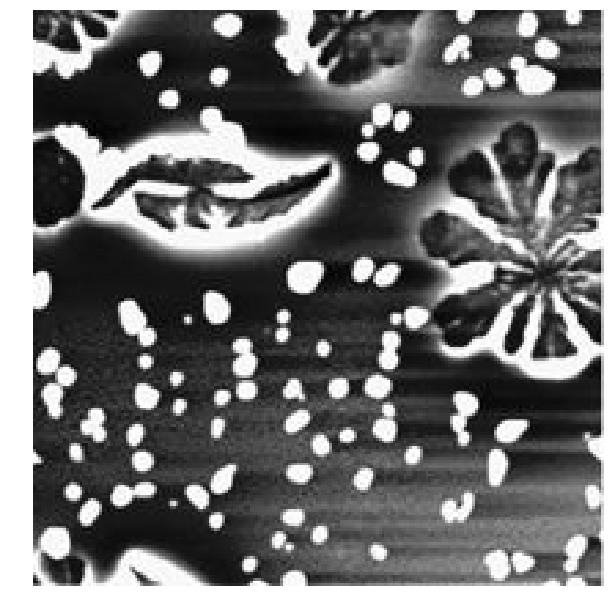

In [3]:
image = cv2.imread(os.path.join(dir_, filename), 0) #считываем изображение в сером
show_gray(image)

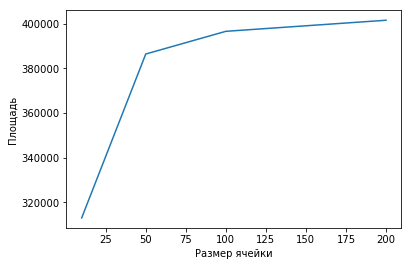

In [8]:
ls = [10, 50, 100, 200] #размеры ячеек
n_iter = 5 #число итераций

def fractal_signature(image, n_iter):
    Vs = []
    image = np.array(image, dtype='int')
    n, m = image.shape
    prev_F_top = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value = 0)
    prev_F_bot = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value = 255)
    for _ in range(1, n_iter + 1):
        F_top = prev_F_top.copy()
        F_bot = prev_F_bot.copy()
        for i, j in itertools.product(range(1, n + 1), range(1, m + 1)):
            F_top[i,j] = max(prev_F_top[i, j] + 1, prev_F_top[i+1, j],
                             prev_F_top[i, j+1], prev_F_top[i-1, j], prev_F_top[i, j-1])
            F_bot[i,j] = min(prev_F_bot[i, j] - 1, prev_F_bot[i+1, j],
                             prev_F_bot[i, j+1], prev_F_bot[i-1, j], prev_F_bot[i, j-1])
        F_top[F_top > 255] = 255
        F_bot[F_bot < 0] = 0
        Vs.append(np.sum(F_top[1:-1, 1:-1] - F_bot[1:-1, 1:-1]))
        prev_F_top = F_top.copy()
        prev_F_bot = F_bot.copy()
    return (Vs[-1] - Vs[-2]) / 2

Ss = []
n, m = image.shape
for l in ls:
    S = 0
    for top, bot in zip(range(0, n - l, l), range(l, n, l)):
        for left, right in zip(range(0, m - l, l), range(l, m, l)):
            S += fractal_signature(image[top:bot, left:right], n_iter)
    Ss.append(S)
    
plt.plot(ls, Ss)
plt.xlabel('Размер ячейки')
plt.ylabel('Площадь')
plt.show()

# Вычисление мультифрактального спектра
## Задание 4. C помощью функции плотности

Выбор изображения

In [9]:
dir_ = 'Silver' # Директория (можно полный путь)
filename = 'large.jpg' #Имя файла

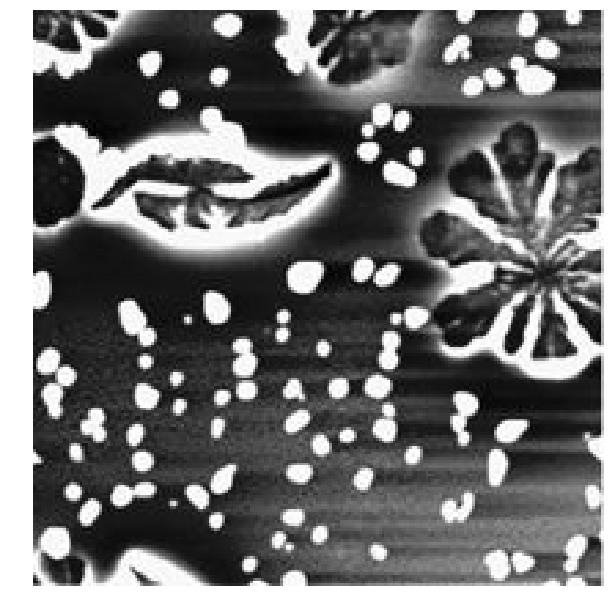

In [10]:
image = cv2.imread(os.path.join(dir_, filename), 0) #считываем изображение в сером
show_gray(image)

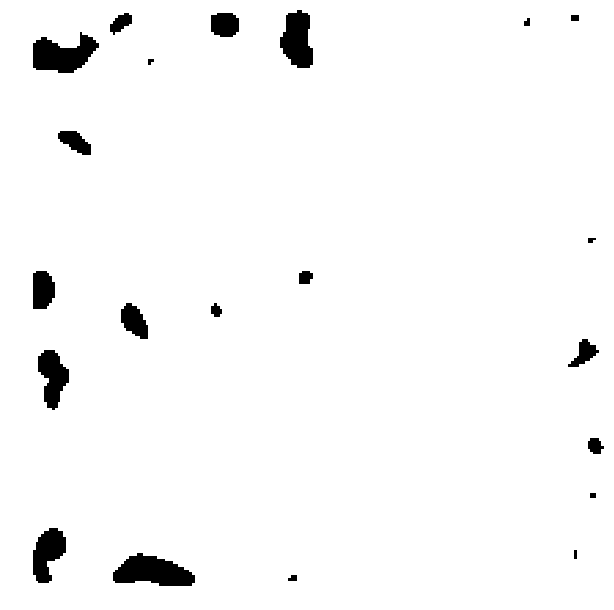

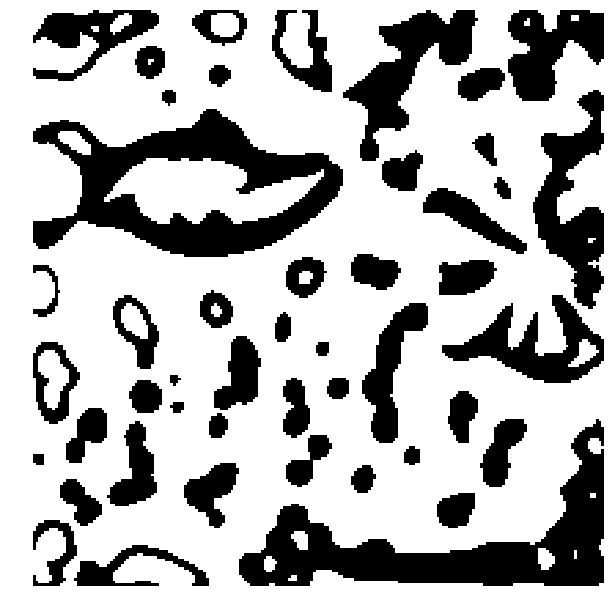

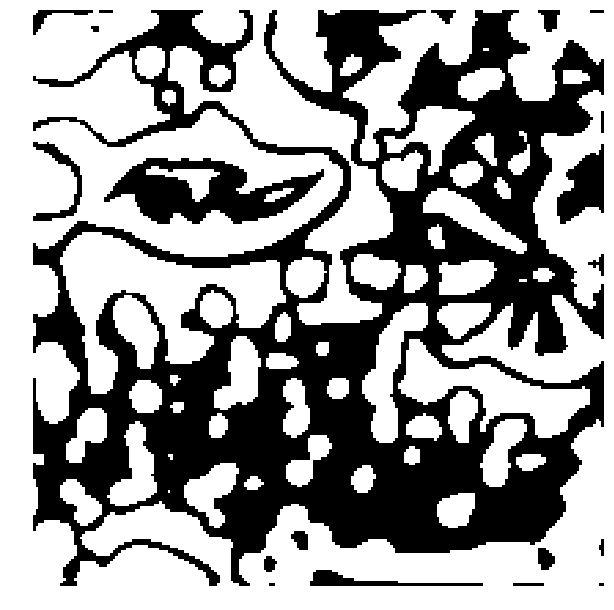

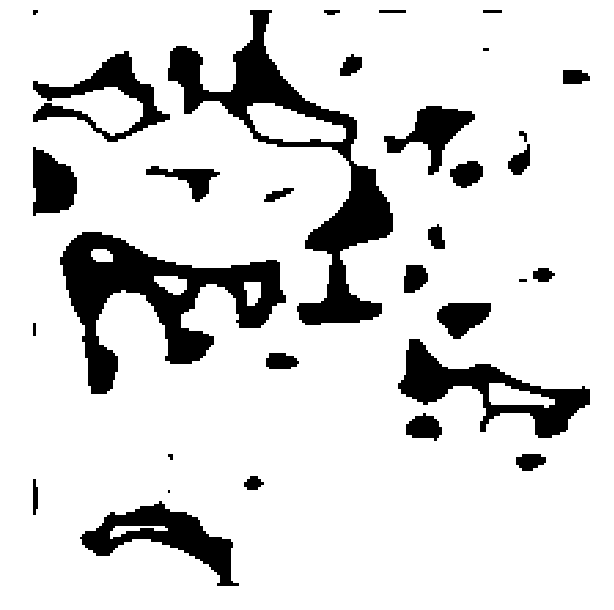

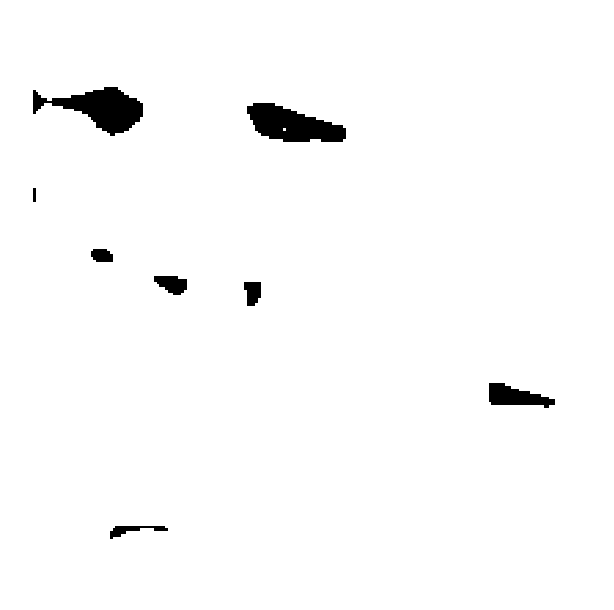

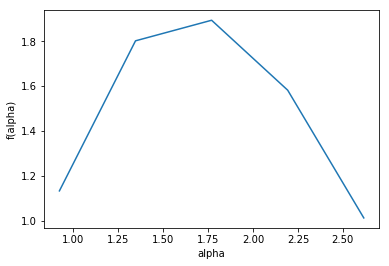

In [31]:
rs = np.arange(2, 30) #радиусы
n_alpha = 6 #число промежутков для alpha (число изображений - уровней на 1 меньше)

def LeastSquares(xs, ys):
    A = np.vstack([xs, np.ones(len(xs))]).T
    k, b = np.linalg.lstsq(A, ys)[0]
    return k

def capacity_dim(img):
    n, m = img.shape
    xs, ys = [], []
    epss, k = [100], 2 #начальный eps и k
    while epss[-1] > 2*k: #пока размер ячейки больше 2*k, уменьшаем eps в k раз
        epss.append(epss[-1] // k)
    for eps in epss:
        N = 0
        for c1, c2 in itertools.product(range(n // eps), range(m // eps)):
            pos1, pos2 = c1*eps, c2*eps
            if 0 in img[pos1:pos1 + eps, pos2:pos2 + eps]:
                N += 1
        xs.append(math.log(eps))
        ys.append(math.log(N))
    xs, ys = np.array(xs), np.array(ys)
    return -LeastSquares(xs, ys)

def calculate_mus_tensor(image, rs):
    n, m = image.shape
    Ms = np.empty((len(rs), n, m))
    for r_id, r in enumerate(rs):
        mus = np.zeros((n, m))
        img = cv2.copyMakeBorder(image, r, r, r, r, cv2.BORDER_CONSTANT, value = 0)
        for (i, j) in itertools.product(range(r, r+n), range(r, r+m)):
            mus[i-r, j-r] = np.sum(img[(i-r):(i+r+1), (j-r):(j+r+1)])
        Ms[r_id] = mus
    return Ms

def calculate_ds(image, rs):
    n, m = image.shape
    ds = np.zeros((n, m))
    Ms = calculate_mus_tensor(image, rs)
    for i, j in itertools.product(range(n), range(m)):
        d = LeastSquares(np.log(rs), np.log(Ms[:,i,j]))
        ds[i,j] = d
    return ds

def calculate_spectre(image, n_alpha, verbose = True):
    F = []
    n, m = image.shape
    ds = calculate_ds(image, rs)
    alphas = np.linspace(np.min(ds), np.max(ds), n_alpha)
    for alpha_l, alpha_r in zip(alphas[:-1], alphas[1:]):
        img = np.full((n, m), 255)
        img[(alpha_l <= ds) * (ds < alpha_r)] = 0
        F.append(capacity_dim(img))
        if verbose == True:
            show_gray(img)
    return (alphas, F)

image = image.astype('float')
alphas, F = calculate_spectre(image, n_alpha, verbose = True)
    
plt.plot(alphas[:-1], F)
plt.xlabel('alpha')
plt.ylabel('f(alpha)')
plt.show()

## Задание 5. C помощью обобщенной статистической суммы

Выбор изображения

In [27]:
dir_ = 'Silver' # Директория (можно полный путь)
filename = 'large.jpg' #Имя файла

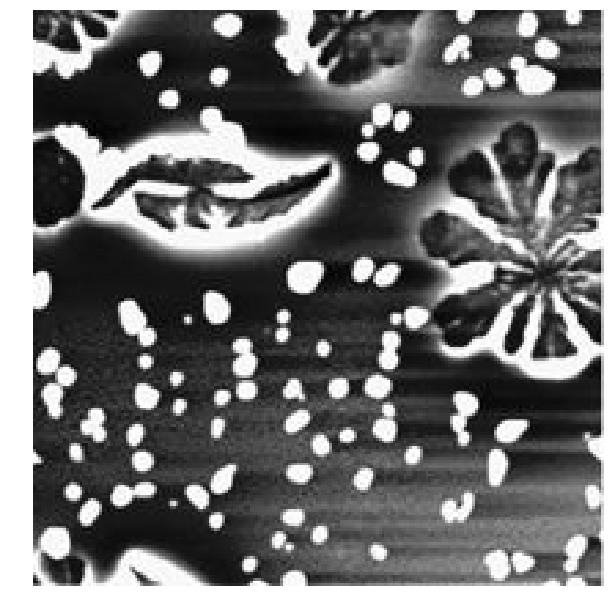

In [28]:
image = cv2.imread(os.path.join(dir_, filename), 0) #считываем изображение в сером
show_gray(image)

In [29]:
qs = np.arange(-5, 5, 0.1) #степени
ls = np.arange(3, 30, 1) #размеры ячеек

def LeastSquares(xs, ys):
    A = np.vstack([xs, np.ones(len(xs))]).T
    k, b = np.linalg.lstsq(A, ys)[0]
    return k

def get_denoninators(M, P):
    y1, y2 = [], []
    for i in range(len(P)):
        y1.append(np.sum(np.log(P[i]) * M[i]))
        y2.append(np.sum(M[i] * np.log(M[i])))
    return (np.array(y1), np.array(y2)) 

fs, alphas = [], []
image = image.astype('float')
n, m = image.shape
for q in qs:
    M, P = [], []
    for l in ls:
        ps = []
        for top, bot in zip(range(0, n-l,  l), range(l, n, l)):
            for left, right in zip(range(0, m-l,  l), range(l, m, l)):
                ps.append(np.sum(image[top:bot, left:right]))
        ps = np.array(ps)
        M.append((ps ** q) / np.sum((ps ** q)))
        P.append(ps)
        
    y1, y2 = get_denoninators(M, P)
    alphas.append(LeastSquares(np.log(ls), y1))
    fs.append(LeastSquares(np.log(ls), y2))

zero.jpg

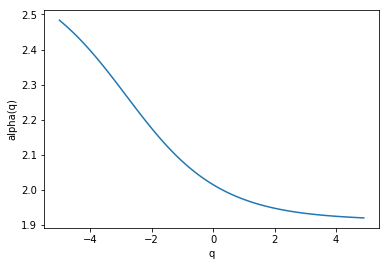

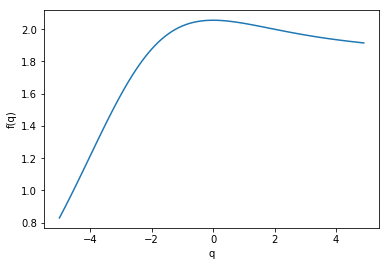

In [20]:
plt.plot(qs, alphas)
plt.xlabel('q')
plt.ylabel('alpha(q)')
plt.show()

plt.plot(qs, fs)
plt.xlabel('q')
plt.ylabel('f(q)')
plt.show()

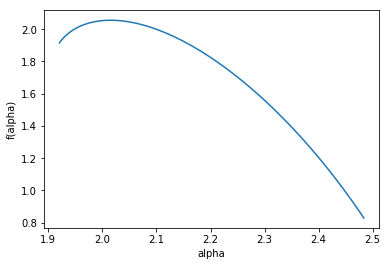

In [21]:
plt.plot(alphas, fs)
plt.xlabel('alpha')
plt.ylabel('f(alpha)')
plt.show()

small.jpg

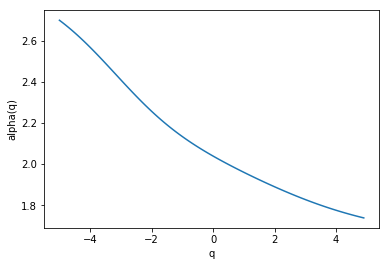

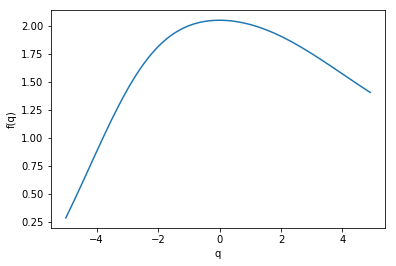

In [25]:
plt.plot(qs, alphas)
plt.xlabel('q')
plt.ylabel('alpha(q)')
plt.show()

plt.plot(qs, fs)
plt.xlabel('q')
plt.ylabel('f(q)')
plt.show()

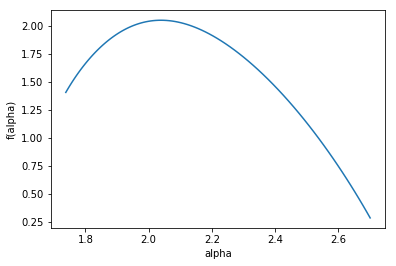

In [26]:
plt.plot(alphas, fs)
plt.xlabel('alpha')
plt.ylabel('f(alpha)')
plt.show()

large.jpg

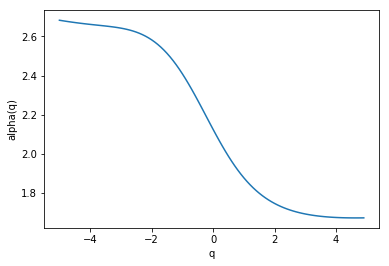

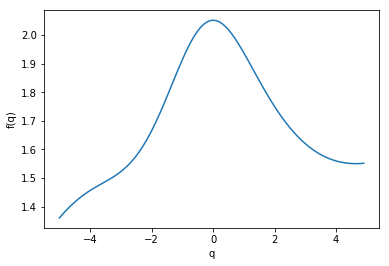

In [30]:
plt.plot(qs, alphas)
plt.xlabel('q')
plt.ylabel('alpha(q)')
plt.show()

plt.plot(qs, fs)
plt.xlabel('q')
plt.ylabel('f(q)')
plt.show()

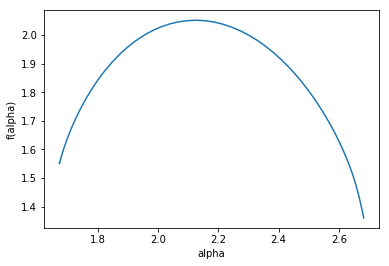

In [31]:
plt.plot(alphas, fs)
plt.xlabel('alpha')
plt.ylabel('f(alpha)')
plt.show()